In [421]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
)
import shap
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve


# 1. Data Exploration & Cleaning

This section evaluates data quality, consistency, and key portfolio characteristics before modeling.

We examine:
- Missing values
- Duplicate records
- Outliers
- Class imbalance
- Correlation and multicollinearity
- PD table monotonicity

In [422]:
file = pd.read_excel("Case_Study_Data_Science_Intern.xlsx", sheet_name=None)

In [423]:
# Analysing Loan Data Table
pd.set_option("display.max_columns", None)
loan_df = file["Loan Data"]
loan_df.head()

,customer_id,age,annual_income,employment_years,property_ownership,property_value,state,loan_amount,loan_term_months,interest_rate,schufa_score,num_credit_lines,credit_utilization,previous_defaults,system_size_kw,estimated_annual_production,installation_cost,estimated_monthly_savings,current_monthly_debt,late_payments_30,late_payments_90,monthly_payment,income_to_loan_ratio,loan_to_income_ratio,debt_to_income,payment_to_income,loan_to_value,savings_coverage_ratio,avg_days_late,max_days_late,avg_payment,payment_std,default_flag
0,1,49,120532,NaN,Mortgage,174979.0,NRW,24977,60,5.964251,8517,0,0.592123,0,4.135256,11308.711381,17294.183210,216.099294,952.850415,0,0,482.460307,4.825720,0.207223,0.094864,0.048033,0.142743,0.447911,3.083333,30,442.255282,139.274294,0
1,2,43,95065,9.0,Mortgage,274117.0,NRW,20735,120,6.109136,8735,4,0.558299,0,7.340403,12257.913470,23049.348097,168.964549,487.859808,3,0,231.339042,4.584760,0.218114,0.061582,0.029202,0.075643,0.730376,0.500000,2,231.339042,0.000000,0
2,3,51,61686,6.0,Own,205760.0,Bavaria,22247,180,6.072445,9604,2,0.365638,0,4.025380,9599.492346,41935.544473,153.777715,362.817903,0,0,188.604676,2.772778,0.360649,0.070580,0.036690,0.108121,0.815344,1.500000,10,188.604676,0.000000,0
3,4,60,43327,8.0,Mortgage,138003.0,Bavaria,22003,120,5.897047,9315,3,0.370674,1,6.256819,13977.769278,15000.000000,165.199094,1317.799401,0,0,243.142389,1.969141,0.507836,0.364982,0.067342,0.159439,0.679434,2.250000,10,233.011456,35.094581,0
4,5,42,84890,0.0,Mortgage,NaN,Lower Saxony,17160,180,6.431666,9250,2,0.869822,0,4.958557,8821.326871,17148.328792,137.974040,973.849621,0,0,148.838149,4.946970,0.202144,0.137663,0.021040,0.095127,0.927007,3.500000,30,136.434970,42.965873,0


In [424]:
loan_df.info()
loan_df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   annual_income                1000 non-null   int64  
 3   employment_years             945 non-null    float64
 4   property_ownership           1000 non-null   object 
 5   property_value               952 non-null    float64
 6   state                        1000 non-null   object 
 7   loan_amount                  1000 non-null   int64  
 8   loan_term_months             1000 non-null   int64  
 9   interest_rate                1000 non-null   float64
 10  schufa_score                 1000 non-null   int64  
 11  num_credit_lines             1000 non-null   int64  
 12  credit_utilization           948 non-null    float64
 13  previous_defaults  

customer_id                    1000
age                              49
annual_income                   918
employment_years                 27
property_ownership                2
property_value                  838
state                             5
loan_amount                     948
loan_term_months                  3
interest_rate                   993
schufa_score                    724
num_credit_lines                  8
credit_utilization              930
previous_defaults                 3
system_size_kw                  981
estimated_annual_production     987
installation_cost               970
estimated_monthly_savings       987
current_monthly_debt            998
late_payments_30                  4
late_payments_90                  3
monthly_payment                1000
income_to_loan_ratio            998
loan_to_income_ratio            998
debt_to_income                  998
payment_to_income              1000
loan_to_value                   998
savings_coverage_ratio      

In [425]:
print("Loan table shape:", loan_df.shape)
print("\nData types:")
print(loan_df.dtypes)


Loan table shape: (1000, 33)

Data types:
customer_id                      int64
age                              int64
annual_income                    int64
employment_years               float64
property_ownership              object
property_value                 float64
state                           object
loan_amount                      int64
loan_term_months                 int64
interest_rate                  float64
schufa_score                     int64
num_credit_lines                 int64
credit_utilization             float64
previous_defaults                int64
system_size_kw                 float64
estimated_annual_production    float64
installation_cost              float64
estimated_monthly_savings      float64
current_monthly_debt           float64
late_payments_30                 int64
late_payments_90                 int64
monthly_payment                float64
income_to_loan_ratio           float64
loan_to_income_ratio           float64
debt_to_income        

In [426]:
# Analysing missing values
print("\nMissing values (%):")
print((loan_df.isna().mean() * 100).sort_values(ascending=False))


Missing values (%):
employment_years               5.5
credit_utilization             5.2
property_value                 4.8
customer_id                    0.0
payment_to_income              0.0
late_payments_90               0.0
monthly_payment                0.0
income_to_loan_ratio           0.0
loan_to_income_ratio           0.0
debt_to_income                 0.0
loan_to_value                  0.0
current_monthly_debt           0.0
savings_coverage_ratio         0.0
avg_days_late                  0.0
max_days_late                  0.0
avg_payment                    0.0
payment_std                    0.0
late_payments_30               0.0
installation_cost              0.0
estimated_monthly_savings      0.0
age                            0.0
estimated_annual_production    0.0
system_size_kw                 0.0
previous_defaults              0.0
num_credit_lines               0.0
schufa_score                   0.0
interest_rate                  0.0
loan_term_months               0.0

### Missing Values

The dataset contains minor missing values (~5%) in employment_years and credit_utilization.

Given the low proportion, these are handled using median imputation within the modeling pipeline to avoid data leakage.

In [427]:
initial_count = len(loan_df)

#Remove 100% identical rows
loan_df = loan_df.drop_duplicates()

#Remove duplicate customers (keeping the one with the highest income as a tie-breaker)
if "annual_income" in loan_df.columns:
    loan_df = loan_df.sort_values("annual_income", ascending=False).drop_duplicates(
        subset=["customer_id"]
    )

final_count = len(loan_df)
print(f"Removed {initial_count - final_count} duplicate records.")

Removed 0 duplicate records.


In [428]:
numeric_cols = loan_df.select_dtypes(include=np.number).columns

outlier_summary = []

for col in numeric_cols:
    if col in ["customer_id", "default_flag"]:
        continue

    Q1 = loan_df[col].quantile(0.25)
    Q3 = loan_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = ((loan_df[col] < lower) | (loan_df[col] > upper)).sum()

    outlier_summary.append(
        {
            "Feature": col,
            "Outlier_Count": outliers,
            "Outlier_%": round(outliers / len(loan_df) * 100, 2),
        }
    )

outlier_df = pd.DataFrame(outlier_summary).sort_values("Outlier_%", ascending=False)

print(outlier_df)

                        Feature  Outlier_Count  Outlier_%
17             late_payments_90            108       10.8
10            previous_defaults             92        9.2
28                  payment_std             47        4.7
22            payment_to_income             46        4.6
25                avg_days_late             45        4.5
19         income_to_loan_ratio             45        4.5
24       savings_coverage_ratio             44        4.4
20         loan_to_income_ratio             43        4.3
1                 annual_income             40        4.0
27                  avg_payment             32        3.2
18              monthly_payment             32        3.2
21               debt_to_income             30        3.0
3                property_value             23        2.3
23                loan_to_value             15        1.5
15         current_monthly_debt             11        1.1
11               system_size_kw              6        0.6
0             

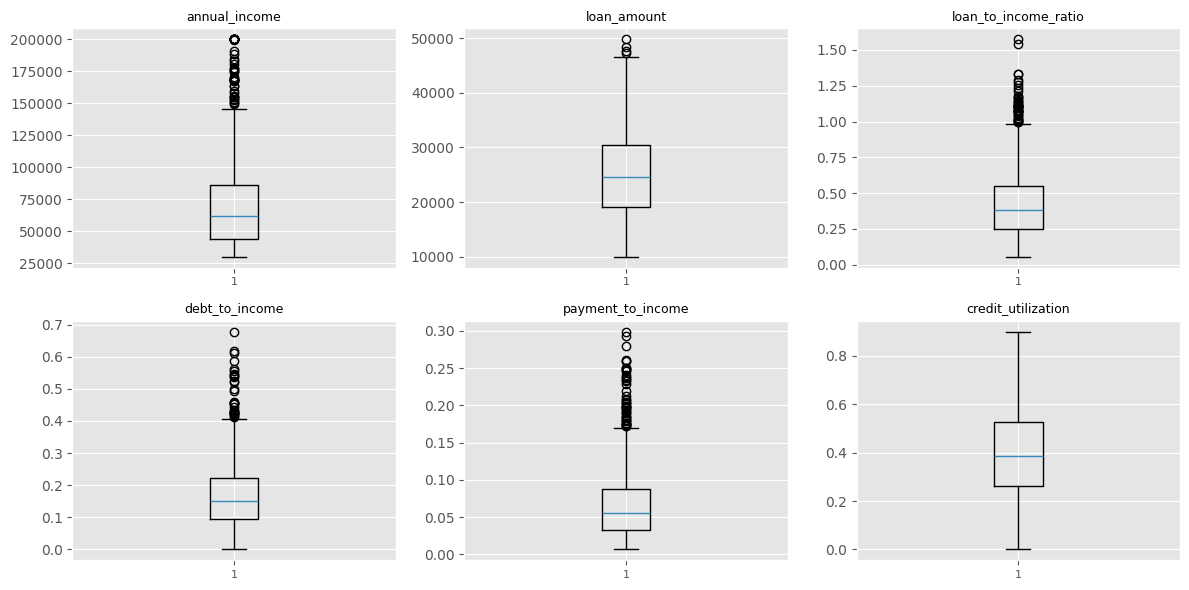

In [429]:
# Box plots to understand outliers 

cols_to_plot = [
    "annual_income",
    "loan_amount",
    "loan_to_income_ratio",
    "debt_to_income",
    "payment_to_income",
    "credit_utilization",
]

fig, axes = plt.subplots(2, 3, figsize=(12, 6)) 

axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    axes[i].boxplot(loan_df[col].dropna(), vert=True)
    axes[i].set_title(col, fontsize=9)
    axes[i].tick_params(axis="x", labelsize=8)

plt.tight_layout()
plt.show()

### Outlier Assessment

Boxplots indicate the presence of upper-tail outliers across several financial variables, particularly income, loan amount, and leverage-related ratios.

These observations are economically plausible in a lending portfolio (e.g., high-income borrowers or large system installations) and do not appear to reflect data errors.

Given that the predictive model uses robust scaling and regularisation, extreme values were retained rather than removed to preserve portfolio realism.

In [430]:
print("\nBasic numeric summary:")
print(loan_df.describe())


Basic numeric summary:
       customer_id          age  annual_income  employment_years  \
count  1000.000000  1000.000000    1000.000000        945.000000   
mean    500.500000    44.728000   70310.411000          9.562963   
std     288.819436     9.622609   34948.120021          4.829564   
min       1.000000    25.000000   30000.000000          0.000000   
25%     250.750000    38.000000   44217.250000          6.000000   
50%     500.500000    45.000000   61792.000000          9.000000   
75%     750.250000    51.000000   86201.000000         13.000000   
max    1000.000000    75.000000  200000.000000         29.000000   

       property_value   loan_amount  loan_term_months  interest_rate  \
count      952.000000   1000.000000       1000.000000    1000.000000   
mean    173344.690126  24802.354000        113.820000       5.517828   
std      65237.034087   7900.209375         40.996198       1.032909   
min     100000.000000  10000.000000         60.000000       3.000000   
25%

### Class Imbalance

Default rate is approximately 3%, indicating significant class imbalance.

Accuracy is therefore not a reliable performance metric.  
AUC and cross-validation are used for robust model evaluation.

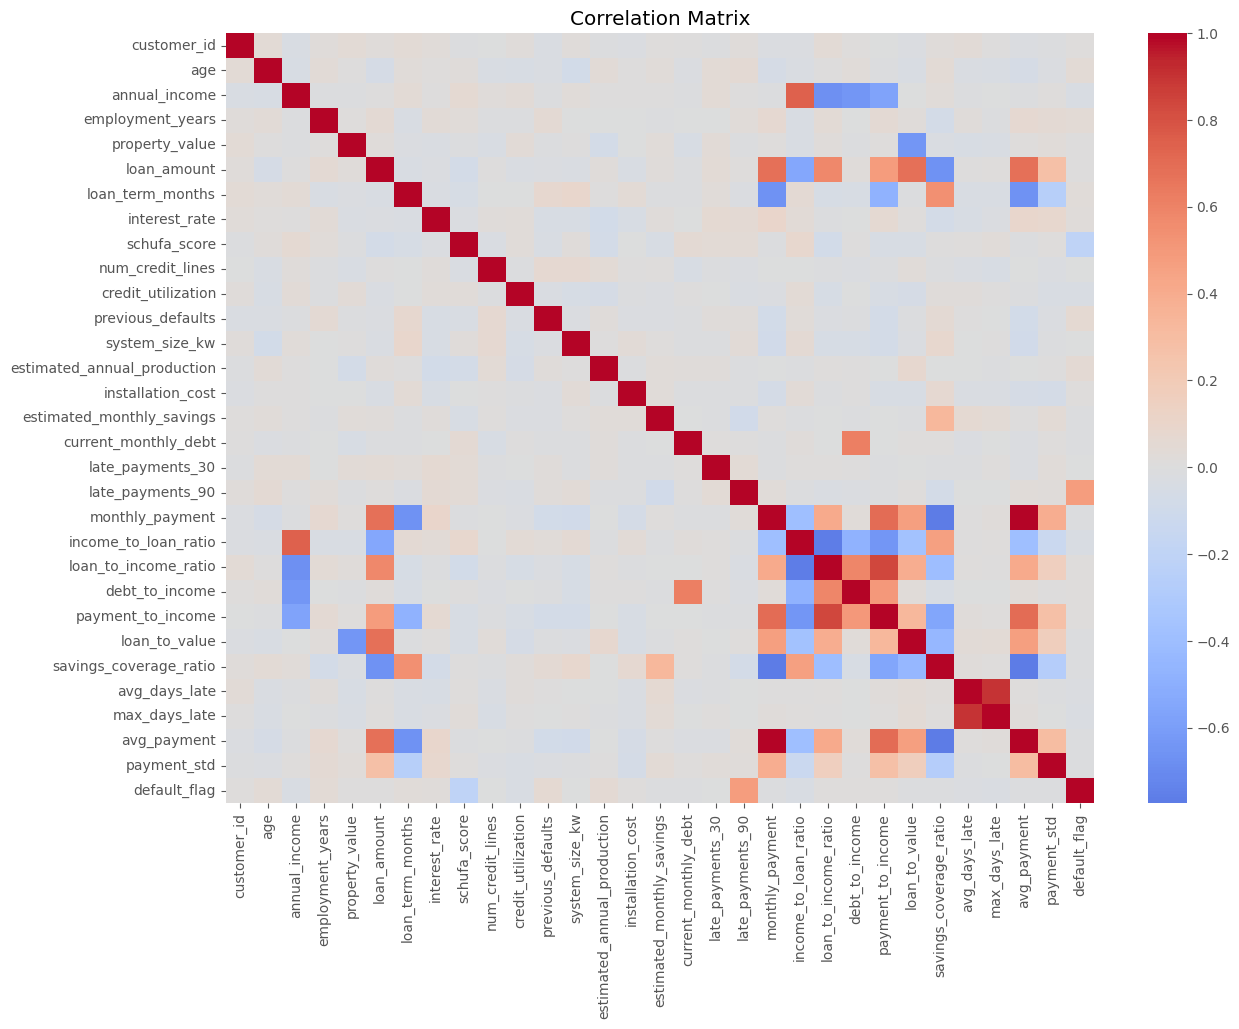

In [431]:
num_cols = loan_df.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(14, 10))
sns.heatmap(loan_df[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

In [432]:
corr_matrix = loan_df[num_cols].corr().abs()

high_corr = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

high_corr.columns = ["Feature1", "Feature2", "Correlation"]

print(high_corr[high_corr["Correlation"] > 0.8])

                 Feature1           Feature2  Correlation
407       monthly_payment        avg_payment     0.993672
421  loan_to_income_ratio  payment_to_income     0.839453
455         avg_days_late      max_days_late     0.900079


In [433]:
print(loan_df[num_cols].corr()["default_flag"].sort_values(ascending=False))

default_flag                   1.000000
late_payments_90               0.477849
previous_defaults              0.063413
estimated_annual_production    0.048976
employment_years               0.041532
age                            0.039253
loan_term_months               0.026976
interest_rate                  0.022047
loan_to_income_ratio           0.014747
customer_id                    0.014181
installation_cost              0.013302
payment_to_income              0.011156
debt_to_income                 0.010638
property_value                 0.006390
loan_amount                    0.004260
num_credit_lines               0.001657
system_size_kw                -0.001164
late_payments_30              -0.004440
savings_coverage_ratio        -0.006663
loan_to_value                 -0.008477
estimated_monthly_savings     -0.009869
payment_std                   -0.010298
avg_payment                   -0.012021
monthly_payment               -0.012301
current_monthly_debt          -0.014429


### Correlation & Multicollinearity

Strong correlations were observed between:
- monthly_payment and avg_payment
- leverage-related ratios

Since these measure similar financial burden concepts, care was taken to avoid double-counting in modeling.

In [434]:


# Select modeling features only (exclude target)
vif_features = [
    "schufa_score",
    "loan_amount",
    "loan_to_income_ratio",
    "debt_to_income",
    "payment_to_income",
    "loan_to_value",
    "annual_income",
    "savings_coverage_ratio",
]

X_vif = loan_df[vif_features].copy()

# Drop missing values for VIF calculation
X_vif = X_vif.dropna()

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))
]

print(vif_data.sort_values("VIF", ascending=False))

                  Feature        VIF
0            schufa_score  58.414397
1             loan_amount  53.471656
2    loan_to_income_ratio  38.005839
6           annual_income  16.419279
4       payment_to_income  14.253454
7  savings_coverage_ratio  10.452010
5           loan_to_value  10.258862
3          debt_to_income   7.711061


score_bin
(7938.999, 8572.9]    0.100000
(8572.9, 8792.0]      0.108911
(8792.0, 8972.7]      0.060606
(8972.7, 9088.6]      0.040000
(9088.6, 9211.0]      0.000000
(9211.0, 9343.0]      0.000000
(9343.0, 9465.3]      0.000000
(9465.3, 9615.0]      0.000000
(9615.0, 9837.2]      0.000000
(9837.2, 9999.0]      0.000000
Name: default_flag, dtype: float64


/var/folders/rw/jr6d5cg96xnbth0d69tljncw0000gn/T/ipykernel_27304/1989894579.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_by_score = loan_df.groupby("score_bin")["default_flag"].mean()


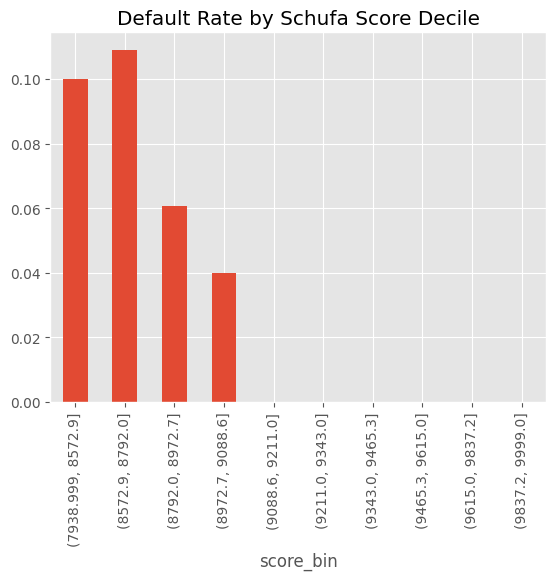

In [435]:
loan_df["score_bin"] = pd.qcut(loan_df["schufa_score"], q=10)

default_by_score = loan_df.groupby("score_bin")["default_flag"].mean()

print(default_by_score)
default_by_score.plot(kind="bar")
plt.title("Default Rate by Schufa Score Decile")
plt.show()

In [436]:
#Analysing Payment History Table

payment_df = file["Payment History"]
payment_df.head()

,customer_id,payment_date,due_date,amount_due,amount_paid,days_late
0,1,2024-01-24 15:33:41.903,2024-01-24 15:33:41.903,482.460307,482.460307,0
1,1,2024-02-23 15:33:41.903,2024-02-23 15:33:41.903,482.460307,482.460307,0
2,1,2024-03-24 15:33:41.903,2024-03-24 15:33:41.903,482.460307,482.460307,0
3,1,2024-04-23 15:33:41.903,2024-04-23 15:33:41.903,482.460307,482.460307,0
4,1,2024-05-25 15:33:41.903,2024-05-23 15:33:41.903,482.460307,482.460307,2


In [437]:
print("payment table shape:", payment_df.shape)
print("\nData types:")
print(payment_df.dtypes)

payment table shape: (12000, 6)

Data types:
customer_id              int64
payment_date    datetime64[ns]
due_date        datetime64[ns]
amount_due             float64
amount_paid            float64
days_late                int64
dtype: object


In [438]:
print("\nMissing values (%):")
print((payment_df.isna().mean() * 100).sort_values(ascending=False))


Missing values (%):
customer_id     0.0
payment_date    0.0
due_date        0.0
amount_due      0.0
amount_paid     0.0
days_late       0.0
dtype: float64


In [439]:
print("Duplicate payment rows:", payment_df.duplicated().sum())

# Check duplicate (customer_id, due_date)
print(
    "Duplicate customer_id + due_date:",
    payment_df.duplicated(subset=["customer_id", "due_date"]).sum(),
)

Duplicate payment rows: 0
Duplicate customer_id + due_date: 0


In [440]:
payment_df.groupby("customer_id").size().describe()

count    1000.0
mean       12.0
std         0.0
min        12.0
25%        12.0
50%        12.0
75%        12.0
max        12.0
dtype: float64

In [441]:
print("\nBasic numeric summary:")
print(payment_df.describe())


Basic numeric summary:
        customer_id                   payment_date  \
count  12000.000000                          12000   
mean     500.500000  2024-07-08 06:33:27.502999808   
min        1.000000     2024-01-14 15:33:41.903000   
25%      250.750000  2024-04-13 15:33:41.903000064   
50%      500.500000  2024-07-12 15:33:41.903000064   
75%      750.250000  2024-10-10 15:33:41.903000064   
max     1000.000000     2025-02-17 15:33:41.903000   
std      288.687019                            NaN   

                            due_date    amount_due   amount_paid     days_late  
count                          12000  12000.000000  12000.000000  12000.000000  
mean   2024-07-07 15:33:41.902999808    317.185026    305.948827      2.631500  
min       2024-01-24 15:33:41.903000     76.197950      0.000000      0.000000  
25%    2024-04-16 03:33:41.903000064    207.403477    196.267295      0.000000  
50%    2024-07-07 15:33:41.903000064    280.740508    275.736036      0.000000  
75%

In [442]:
pct_late = (payment_df["days_late"] > 0).mean()
pct_30 = (payment_df["days_late"] >= 30).mean()
pct_90 = (payment_df["days_late"] >= 90).mean()

print(pct_late, pct_30, pct_90)

0.29175 0.028166666666666666 0.0


In [443]:
result = (payment_df["days_late"] >= 90).sum()
print(int(result))

0


In [444]:
loan_df["late_payments_90"].value_counts()

late_payments_90
0    892
1    103
2      5
Name: count, dtype: int64

In [445]:
loan_df.groupby("late_payments_90")["default_flag"].mean()

late_payments_90
0    0.000000
1    0.300971
2    0.000000
Name: default_flag, dtype: float64

### Payment History Usage

The payment history dataset represents post-origination behavioral data.

Since the predictive model aims to estimate default probability at loan origination, only features available at approval time were included.

Behavioral features (e.g., recent payment delinquency) would introduce data leakage and were therefore excluded from the origination PD model.

However, payment history remains valuable for:

- Portfolio monitoring
- Early warning systems
- Dynamic risk re-pricing
- Collections prioritization

In [446]:
pd_df = file["Schufa PD 12 Distribution"]
pd_df

,Rating Level (HYPO),FROM (HYPO),TO (HYPO),PD-12 Hypo
0,A,9935,9999,0.001369
1,B,9910,9934,0.002506
2,C,9891,9909,0.003043
3,D,9863,9890,0.003546
4,E,9822,9862,0.005160
5,F,9750,9821,0.007252
6,G,9591,9749,0.011226
7,H,9373,9590,0.018127
8,I,9166,9372,0.027165
9,K,8959,9165,0.034403


In [447]:
# analysing the Schufa PD 12 Distribution table
print("PD table shape:", pd_df.shape)
print("\nData types:")
print(pd_df.dtypes)

print("\nMissing values (%):")
print((pd_df.isna().mean() * 100).sort_values(ascending=False))

print("\nBasic numeric summary:")
print(pd_df.describe())

PD table shape: (15, 4)

Data types:
Rating Level (HYPO)     object
FROM (HYPO)              int64
TO (HYPO)                int64
PD-12 Hypo             float64
dtype: object

Missing values (%):
Rating Level (HYPO)    0.0
FROM (HYPO)            0.0
TO (HYPO)              0.0
PD-12 Hypo             0.0
dtype: float64

Basic numeric summary:
       FROM (HYPO)    TO (HYPO)  PD-12 Hypo
count    15.000000    15.000000   15.000000
mean   8344.866667  9010.466667    0.054868
std    2672.140898  1373.700418    0.093902
min       1.000000  4871.000000    0.001369
25%    8250.500000  8729.000000    0.004353
50%    9373.000000  9590.000000    0.018127
75%    9842.500000  9876.000000    0.055634
max    9935.000000  9999.000000    0.360036


In [448]:
# Monotonicity check for PD-12: PD should generally increase as rating worsens

pd_df_sorted = pd_df.sort_values(by="FROM (HYPO)", ascending=False).reset_index(
    drop=True
)

pd_values = pd_df_sorted["PD-12 Hypo"].values

# Find any decreases in PD (non-monotonic)
decreases = pd_df_sorted["PD-12 Hypo"].diff().fillna(0) < 0

if decreases.any():
    print("\nNon-monotonic entries in PD-12 (unexpected drops):")
    
    cols_to_show = ["Rating Level (HYPO)", "FROM (HYPO)", "TO (HYPO)", "PD-12 Hypo"]
    print(pd_df_sorted[decreases][cols_to_show])

    # Highlight row 'M' specifically if present
    if "M" in pd_df_sorted["Rating Level (HYPO)"].values:
        print("\nEntry for rating 'M':")
        print(
            pd_df_sorted[pd_df_sorted["Rating Level (HYPO)"] == "M"][cols_to_show]
        )


Non-monotonic entries in PD-12 (unexpected drops):
   Rating Level (HYPO)  FROM (HYPO)  TO (HYPO)  PD-12 Hypo
12                   N         7539       7999    0.062642

Entry for rating 'M':
   Rating Level (HYPO)  FROM (HYPO)  TO (HYPO)  PD-12 Hypo
11                   M         8000       8500    0.088141


In [449]:



pd_df = pd_df.sort_values(by="FROM (HYPO)", ascending=False).reset_index(
    drop=True
)

#Apply the cumulative maximum to fix the drops (like at Rating N)
pd_df["PD-12 Hypo"] = np.maximum.accumulate(pd_df["PD-12 Hypo"])


print(pd_df[["Rating Level (HYPO)", "PD-12 Hypo"]])


   Rating Level (HYPO)  PD-12 Hypo
0                    A    0.001369
1                    B    0.002506
2                    C    0.003043
3                    D    0.003546
4                    E    0.005160
5                    F    0.007252
6                    G    0.011226
7                    H    0.018127
8                    I    0.027165
9                    K    0.034403
10                   L    0.048626
11                   M    0.088141
12                   N    0.088141
13                   O    0.149781
14                   P    0.360036


### PD Table Validation

The Schufa PD-12 distribution was checked for monotonicity.  
One rating band showed a slight inconsistency and was corrected to maintain increasing PD with worsening rating.

This ensures logical alignment between rating and probability of default.

In [450]:
#Feature Engineering

# Map schufa_score to rating band and PD-12 value
from_col = [c for c in pd_df.columns if "FROM" in c][0]
to_col = [c for c in pd_df.columns if "TO" in c][0]
rating_col = [c for c in pd_df.columns if "Rating Level" in c][0]
pd_col = [c for c in pd_df.columns if "PD-12" in c][0]
loan_df["rating"] = None
loan_df["PD_12"] = np.nan
for _, band in pd_df_sorted.iterrows():
    mask = (loan_df["schufa_score"] >= band[from_col]) & (
        loan_df["schufa_score"] <= band[to_col]
    )
    loan_df.loc[mask, "rating"] = band[rating_col]
    loan_df.loc[mask, "PD_12"] = band[pd_col]

unmapped = loan_df["rating"].isnull().sum()
if unmapped > 0:
    print(f"\nWarning: {unmapped} records have schufa_score outside PD bands.")

loan_df.sample(10)

,customer_id,age,annual_income,employment_years,property_ownership,property_value,state,loan_amount,loan_term_months,interest_rate,schufa_score,num_credit_lines,credit_utilization,previous_defaults,system_size_kw,estimated_annual_production,installation_cost,estimated_monthly_savings,current_monthly_debt,late_payments_30,late_payments_90,monthly_payment,income_to_loan_ratio,loan_to_income_ratio,debt_to_income,payment_to_income,loan_to_value,savings_coverage_ratio,avg_days_late,max_days_late,avg_payment,payment_std,default_flag,score_bin,rating,PD_12
19,20,30,74019,3.0,Mortgage,100000.0,NRW,37322,60,3.664231,9647,4,0.228120,0,9.599775,6428.517436,38945.348387,173.839236,689.084995,0,0,681.700734,1.983254,0.504222,0.111715,0.110518,0.373220,0.255008,2.666667,30,681.700734,0.000000,0,"(9615.0, 9837.2]",G,0.011226
133,134,49,75114,12.0,Mortgage,178027.0,Bavaria,20169,120,5.001013,9496,4,0.173786,0,10.083466,6727.396430,27759.806137,173.843221,339.745712,1,0,213.933522,3.724230,0.268512,0.054277,0.034177,0.113292,0.812604,0.333333,2,205.019625,30.878644,0,"(9465.3, 9615.0]",H,0.018127
601,602,35,119066,13.0,Mortgage,NaN,Baden-Württemberg,26059,180,6.223038,9174,1,0.282378,0,8.637654,8732.422708,26773.481861,113.192530,804.861980,0,0,223.053073,4.569093,0.218862,0.081118,0.022480,0.126692,0.507469,2.000000,10,213.759195,32.194938,0,"(9088.6, 9211.0]",I,0.027165
310,311,42,59129,8.0,Own,154373.0,Baden-Württemberg,10000,60,5.000128,8639,0,0.072351,0,5.875519,8677.956237,32473.261756,162.833068,573.766256,1,0,188.712921,5.912900,0.169122,0.116444,0.038299,0.064778,0.862861,5.416667,30,188.712921,0.000000,0,"(8572.9, 8792.0]",L,0.048626
688,689,52,68984,13.0,Own,135338.0,Bavaria,16972,120,4.618566,9428,0,NaN,0,9.067253,8287.830256,27410.807642,136.478803,835.353298,0,0,176.866741,4.064577,0.246028,0.145313,0.030767,0.125405,0.771648,1.416667,10,162.127846,34.422643,0,"(9343.0, 9465.3]",H,0.018127
504,505,38,54990,4.0,Mortgage,100000.0,Baden-Württemberg,38658,180,4.179923,8121,3,0.229843,0,10.077454,12818.868848,39365.430310,127.997245,707.950477,0,0,289.446600,1.422474,0.703001,0.154490,0.063163,0.386580,0.442214,3.083333,30,289.446600,0.000000,0,"(7938.999, 8572.9]",M,0.088141
544,545,25,44306,22.0,Mortgage,220112.0,Hesse,23344,120,6.810606,9999,1,0.725066,1,11.876190,10010.915689,28001.819104,130.664769,541.576181,0,0,268.770492,1.897961,0.526881,0.146682,0.072795,0.106055,0.486157,2.416667,10,268.770492,0.000000,0,"(9837.2, 9999.0]",A,0.001369
625,626,39,102746,5.0,Own,100000.0,Bavaria,23804,120,4.996350,9736,2,NaN,0,11.214038,5000.000000,27132.430486,194.283446,448.687688,0,0,252.435883,4.316333,0.231678,0.052404,0.029483,0.238040,0.769635,3.916667,30,252.435883,0.000000,0,"(9615.0, 9837.2]",G,0.011226
932,933,30,47445,5.0,Mortgage,243497.0,NRW,28508,120,4.858835,9310,2,0.301839,0,4.296826,13638.154380,28296.170748,151.988242,696.458831,0,0,300.408332,1.664270,0.600864,0.176151,0.075981,0.117077,0.505939,1.750000,10,275.374304,58.466892,0,"(9211.0, 9343.0]",I,0.027165
672,673,41,49223,11.0,Mortgage,261826.0,Bavaria,35660,60,4.206878,9103,3,0.362685,0,11.628506,9940.984803,35368.208091,131.304591,715.076278,0,0,660.067600,1.380342,0.724458,0.174327,0.160917,0.136197,0.198926,3.666667,30,632.564784,95.272552,0,"(9088.6, 9211.0]",K,0.034403


### PD-12 Mapping (Optional Enhancement)

We also mapped Schufa score to bureau PD-12 bands using the provided rating table.

This produces a calibrated risk proxy (`PD_12`) that can be used instead of the raw score.

# 2. Risk Profiling

Customers were segmented into Low, Medium, and High risk categories based on:

- Credit quality (schufa_score)
- Affordability (loan-to-income, debt-to-income, payment-to-income)
- Renewable cushion (savings_coverage_ratio)

This segmentation aims to test whether structural risk differentiation exists in the portfolio.

In [451]:



df = loan_df.copy()


# 1 CREDIT TIER (3 = Best)

df["credit_tier"] = pd.qcut(df["schufa_score"], 3, labels=[1, 2, 3]).astype(int)


# 2 AFFORDABILITY TIER
# Use only dimensionless burden ratios
# Higher burden = worse 

df["afford_score_raw"] = (
    df["loan_to_income_ratio"] + df["debt_to_income"] + df["payment_to_income"]
)

df["afford_tier"] = pd.qcut(
    df["afford_score_raw"], 3, labels=[3, 2, 1]  # 3 = safest
).astype(int)


# 3 RENEWABLE CUSHION TIER (3 = Best)

df["cushion_tier"] = pd.qcut(df["savings_coverage_ratio"], 3, labels=[1, 2, 3]).astype(
    int
)

# 4 FINAL RISK SEGMENT
# Total score range: 3 to 9

df["total_score"] = df["credit_tier"] + df["afford_tier"] + df["cushion_tier"]


def assign_segment(score):
    if score >= 7:
        return "Low"
    elif score >= 5:
        return "Medium"
    else:
        return "High"


df["risk_segment"] = df["total_score"].apply(assign_segment)

print("\nSegment Distribution:")
print(df["risk_segment"].value_counts())

print("\nDefault Rate by Segment:")
print(df.groupby("risk_segment")["default_flag"].mean().round(4))


Segment Distribution:
risk_segment
Medium    425
Low       390
High      185
Name: count, dtype: int64

Default Rate by Segment:
risk_segment
High      0.0757
Low       0.0154
Medium    0.0259
Name: default_flag, dtype: float64


/var/folders/rw/jr6d5cg96xnbth0d69tljncw0000gn/T/ipykernel_27304/2009314480.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/var/folders/rw/jr6d5cg96xnbth0d69tljncw0000gn/T/ipykernel_27304/2009314480.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/rw/jr6d5cg96xnbth0d69tljncw0000gn/T/ipykernel_27304/2009314480.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


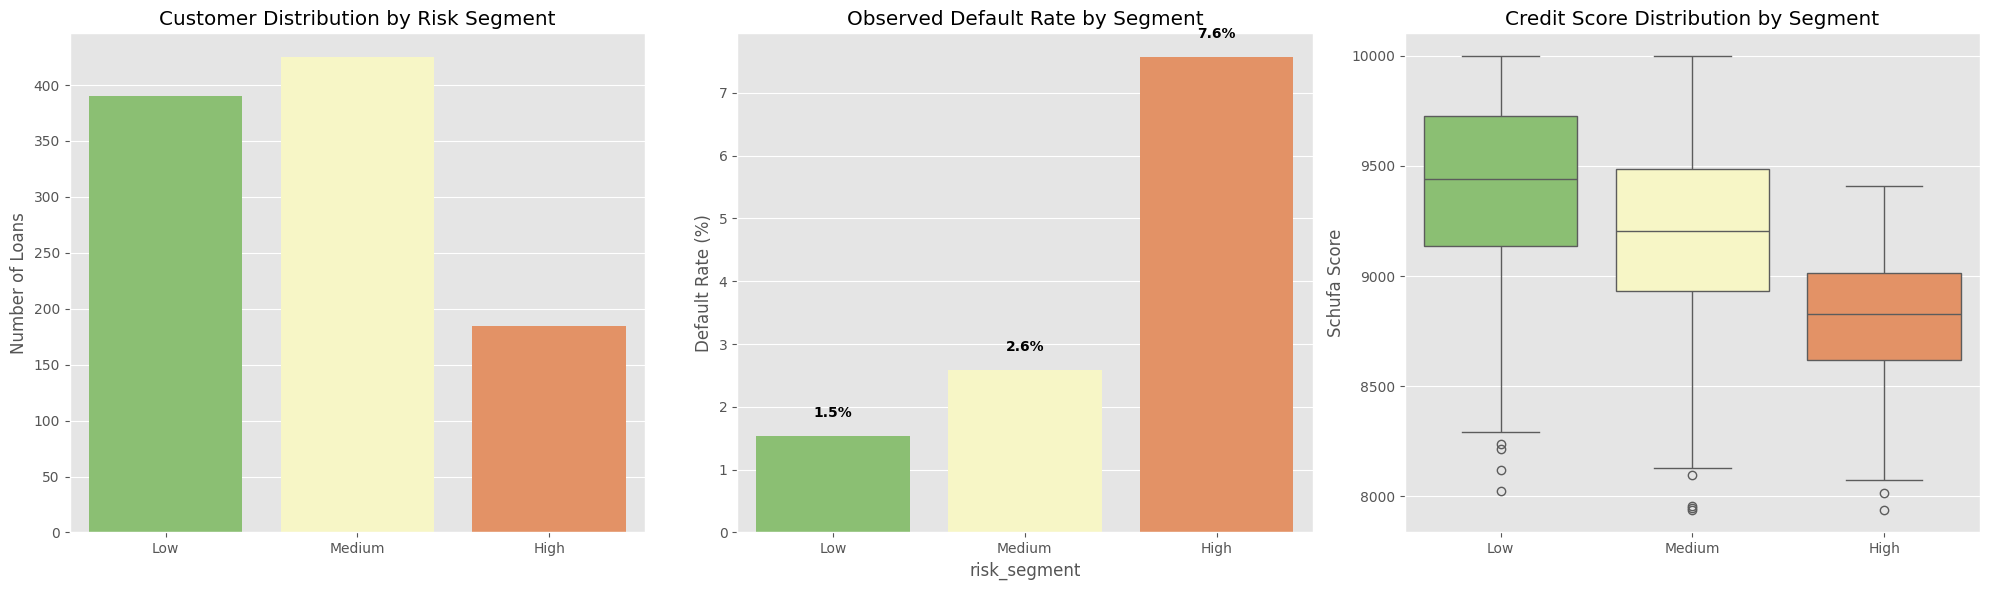

In [452]:
plt.style.use("ggplot")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Distribution
sns.countplot(
    data=df,
    x="risk_segment",
    order=["Low", "Medium", "High"],
    palette="RdYlGn_r",
    ax=axes[0],
)
axes[0].set_title("Customer Distribution by Risk Segment")
axes[0].set_xlabel("")
axes[0].set_ylabel("Number of Loans")

# 2. Default Rate
default_rates = (
    df.groupby("risk_segment")["default_flag"].mean().reindex(["Low", "Medium", "High"])
    * 100
)
sns.barplot(
    x=default_rates.index, y=default_rates.values, palette="RdYlGn_r", ax=axes[1]
)
axes[1].set_title("Observed Default Rate by Segment")
axes[1].set_ylabel("Default Rate (%)")

for i, v in enumerate(default_rates.values):
    axes[1].text(i, v + 0.3, f"{v:.1f}%", ha="center", fontweight="bold")

# 3. Credit Score Separation
sns.boxplot(
    data=df,
    x="risk_segment",
    y="schufa_score",
    order=["Low", "Medium", "High"],
    palette="RdYlGn_r",
    ax=axes[2],
)
axes[2].set_title("Credit Score Distribution by Segment")
axes[2].set_xlabel("")
axes[2].set_ylabel("Schufa Score")

plt.tight_layout()


plt.savefig("risk_segment_dashboard.jpg", dpi=300, bbox_inches="tight")

# Show comes LAST
plt.show()

In [453]:
summary = (
    df.groupby("risk_segment")
    .agg(
        customers=("default_flag", "count"),
        default_rate=("default_flag", "mean"),
        avg_schufa=("schufa_score", "mean"),
        avg_income=("annual_income", "mean"),
        avg_loan=("loan_amount", "mean"),
        avg_interest_rate=("interest_rate", "mean"),
    )
    .reindex(["Low", "Medium", "High"])
)

summary["default_rate"] *= 100

print("\nExecutive Summary:")
print(summary.round(2))


Executive Summary:
              customers  default_rate  avg_schufa  avg_income  avg_loan  \
risk_segment                                                              
Low                 390          1.54     9391.82    86915.07  20077.54   
Medium              425          2.59     9191.24    64527.94  26407.59   
High                185          7.57     8815.78    48590.06  31075.08   

              avg_interest_rate  
risk_segment                     
Low                        5.51  
Medium                     5.46  
High                       5.66  


### Risk Segmentation Results

The segmentation shows clear monotonic separation:

- Low Risk: 1.5%% default rate
- Medium Risk: ~2–3%
- High Risk: ~7–8%

This confirms meaningful structural risk differentiation across borrowers.

In [454]:
loan_df["interest_rate"].corr(loan_df["schufa_score"])
loan_df["interest_rate"].corr(loan_df["loan_to_income_ratio"])
loan_df["interest_rate"].corr(loan_df["debt_to_income"])

np.float64(-0.003756313179454217)

Detailed Interest Rate Statistics by Segment:
                  mean    median       std       min       max
risk_segment                                                  
High          5.661878  5.666485  0.981543  3.121004  8.198329
Low           5.512033  5.448174  1.052260  3.000000  8.877383
Medium        5.460441  5.442939  1.033166  3.000000  8.324220


/var/folders/rw/jr6d5cg96xnbth0d69tljncw0000gn/T/ipykernel_27304/2237917386.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


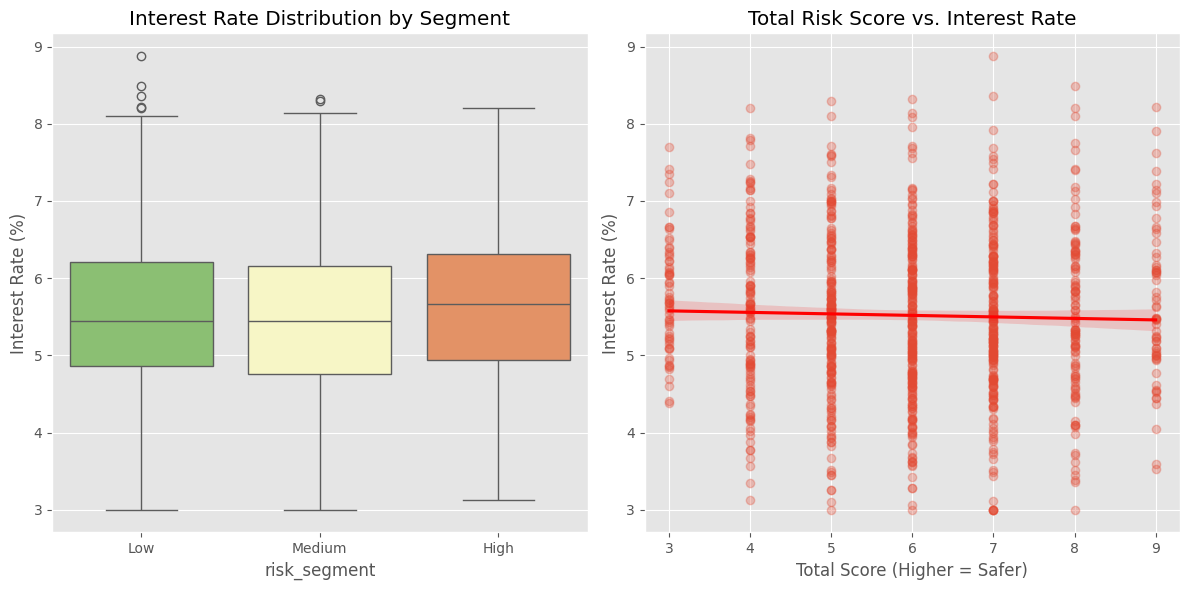


Correlation between Loan Amount and Interest Rate:
-0.019


In [455]:
# 1. Statistical Validation
# Checking if the mean is skewed by outliers
pricing_stats = df.groupby("risk_segment")["interest_rate"].agg(
    ["mean", "median", "std", "min", "max"]
)
print("Detailed Interest Rate Statistics by Segment:")
print(pricing_stats)

# 2. Visualization: The Pricing vs. Risk Gap
plt.figure(figsize=(12, 6))

# Plot A: Boxplot to see the distribution and outliers
plt.subplot(1, 2, 1)
sns.boxplot(
    data=df,
    x="risk_segment",
    y="interest_rate",
    order=["Low", "Medium", "High"],
    palette="RdYlGn_r",
)
plt.title("Interest Rate Distribution by Segment")
plt.ylabel("Interest Rate (%)")

# Plot B: Scatter plot to see the 'Cloud' of pricing
plt.subplot(1, 2, 2)
sns.regplot(
    data=df,
    x="total_score",
    y="interest_rate",
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"},
)
plt.title("Total Risk Score vs. Interest Rate")
plt.xlabel("Total Score (Higher = Safer)")
plt.ylabel("Interest Rate (%)")

plt.tight_layout()
plt.savefig("pricing_inefficiency_analysis.jpg", dpi=300, bbox_inches="tight")
plt.show()

# 3. Deep Dive: Why is 'Low' higher than 'Medium'?
# Checking if loan size is influencing the rate (Smaller loans often have higher rates)
print("\nCorrelation between Loan Amount and Interest Rate:")
print(df[["loan_amount", "interest_rate"]].corr().iloc[0, 1].round(4))

### Pricing Observation

Interest rates vary only marginally across segments (~5.46%–5.66%), despite significant differences in default rates.

This suggests pricing does not fully reflect observed credit risk.

# 3. Predictive Modeling

A logistic regression model was built to estimate default probability using structural, pre-origination variables such as:

- schufa_score
- loan_amount
- loan_to_income_ratio
- leverage and cushion metrics

Performance was evaluated using AUC and 5-fold cross-validation due to class imbalance.

In [456]:
# Final feature set (reduced multicollinearity)

features = [
    "schufa_score",
    "loan_to_income_ratio",
    "debt_to_income",
    "loan_to_value",
    "savings_coverage_ratio",
    
]

X = loan_df[features]
y = loan_df["default_flag"]

X = loan_df[features]
y = loan_df["default_flag"]



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [457]:


X_vif = loan_df[features].copy().dropna()

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])
]

print(vif_data.sort_values("VIF", ascending=False))

                  Feature        VIF
0            schufa_score  18.428688
1    loan_to_income_ratio   8.668935
3           loan_to_value   7.657816
2          debt_to_income   6.506135
4  savings_coverage_ratio   6.136098


### Multicollinearity Assessment

Variance Inflation Factor (VIF) indicates moderate collinearity between credit score and leverage-related variables.

This is economically expected: lower credit quality borrowers tend to have higher leverage and weaker affordability metrics.

Since the objective is predictive accuracy rather than causal inference, and model performance remains stable (CV AUC ~0.83), the final feature set is retained.

In [458]:

# Logistic Regression Pipeline
# Median imputation (avoid leakage)
# Standard scaling (required for LR)
# Class weight balanced (handle imbalance)

log_pipeline_final = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(class_weight="balanced", max_iter=1000)),
    ]
)

log_pipeline_final.fit(X_train, y_train)

log_proba = log_pipeline_final.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, log_proba)
pr_auc = average_precision_score(y_test, log_proba)

print("Final Logistic Model")
print("AUC:", round(auc, 4))
print("PR-AUC:", round(pr_auc, 4))

Final Logistic Model
AUC: 0.8438
PR-AUC: 0.1221


### Initial Model Performance

The logistic regression model achieved strong discriminatory power (AUC ≈ 0.83 on a hold-out split).

However, to ensure stability, cross-validation was performed.

In [459]:
# Stratified because of imbalance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc_scores = cross_val_score(log_pipeline_final, X, y, cv=cv, scoring="roc_auc")

print("CV AUC scores:", np.round(cv_auc_scores, 4))
print("Mean CV AUC:", round(cv_auc_scores.mean(), 4))
print("Std CV AUC:", round(cv_auc_scores.std(), 4))

CV AUC scores: [0.9055 0.7388 0.8806 0.8333 0.8756]
Mean CV AUC: 0.8468
Std CV AUC: 0.0587


### Cross-Validation Results

The final logistic regression model achieves:

- Test AUC: 0.84  
- 5-fold CV AUC: 0.85 (std ≈ 0.06)

The close alignment between test AUC and cross-validation AUC indicates stable generalisation and limited overfitting.

Despite reducing the feature set to address multicollinearity, predictive performance remains strong.

This suggests that default risk in the portfolio is largely driven by a small number of core structural risk factors.

In [460]:
#feature importance
log_model = log_pipeline_final.named_steps["model"]

coef_df = pd.DataFrame({"Feature": features, "Coefficient": log_model.coef_[0]})

coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False)

print("\nLogistic Regression Coefficients (standardized):")
print(coef_df.drop(columns="Abs_Coefficient"))


Logistic Regression Coefficients (standardized):
                  Feature  Coefficient
0            schufa_score    -2.056079
2          debt_to_income     0.522659
3           loan_to_value    -0.255303
1    loan_to_income_ratio    -0.194162
4  savings_coverage_ratio    -0.155766


In [461]:
def run_model(feature_list):
    X = loan_df[feature_list]
    y = loan_df["default_flag"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    pipe = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(class_weight="balanced", max_iter=1000)),
        ]
    )

    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]

    return roc_auc_score(y_test, proba)


full_features = [
    "schufa_score",
    "loan_to_income_ratio",
    "debt_to_income",
    "loan_to_value",
    "savings_coverage_ratio",
]

no_score_features = [
    "loan_to_income_ratio",
    "debt_to_income",
    "loan_to_value",
    "savings_coverage_ratio",
]

auc_full = run_model(full_features)
auc_no_score = run_model(no_score_features)

print("AUC with schufa_score:", round(auc_full, 4))
print("AUC without schufa_score:", round(auc_no_score, 4))

AUC with schufa_score: 0.8438
AUC without schufa_score: 0.4101


### Multicollinearity Sensitivity Check

Although VIF for schufa_score remains elevated, a sensitivity analysis was conducted by removing the variable.

Model discrimination (AUC) decreases materially when schufa_score is excluded, confirming that it provides unique predictive information beyond leverage variables.

Given the objective is predictive accuracy (not causal estimation), schufa_score was retained in the final model despite multicollinearity.

### Model Interpretation

Credit score (schufa_score) is the dominant driver of default risk.

A one standard deviation increase in credit score significantly reduces the probability of default, confirming that bureau-based credit quality is the primary risk signal.

Debt-to-income ratio increases default risk, reflecting financial stress and repayment burden.

Leverage-related metrics (loan-to-income ratio and loan-to-value) and savings coverage provide incremental explanatory power.

Overall, default risk appears primarily driven by credit quality and affordability rather than renewable system characteristics.

In [462]:

# Gradient Boosting Pipeline
# Median imputation only
# No scaling needed

gb_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        (
            "model",
            GradientBoostingClassifier(
                n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42
            ),
        ),
    ]
)

gb_pipeline.fit(X_train, y_train)

gb_proba = gb_pipeline.predict_proba(X_test)[:, 1]

gb_auc = roc_auc_score(y_test, gb_proba)
gb_pr_auc = average_precision_score(y_test, gb_proba)

print("\nGradient Boosting Results")
print("AUC:", round(gb_auc, 4))
print("PR-AUC:", round(gb_pr_auc, 4))


Gradient Boosting Results
AUC: 0.8511
PR-AUC: 0.1003


### Model Comparison

Gradient Boosting achieved AUC = 0.85, only marginally higher than Logistic Regression (AUC = 0.84).

Given the minimal performance gain and the superior interpretability of logistic regression, the simpler model is preferred for deployment.

This suggests default risk in the portfolio is largely driven by linear relationships, particularly credit score and leverage ratios.

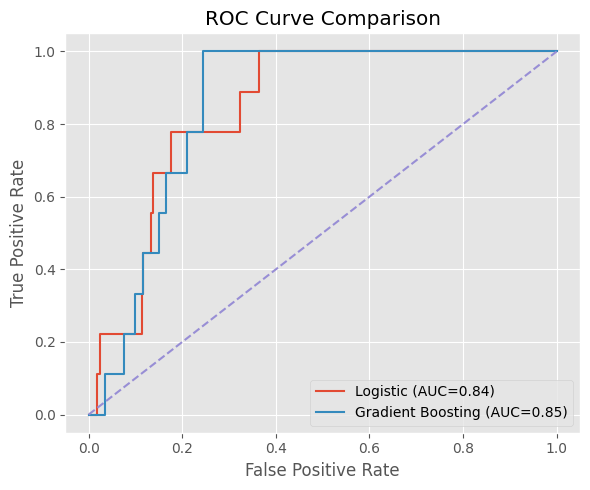

In [463]:
# Compute AUC values
log_auc = roc_auc_score(y_test, log_proba)
gb_auc = roc_auc_score(y_test, gb_proba)

# Compute ROC curves
fpr_log, tpr_log, _ = roc_curve(y_test, log_proba)
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_proba)


plt.figure(figsize=(6, 5))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC={log_auc:.2f})")
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC={gb_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()

In [464]:


# Logistic KS
fpr_log, tpr_log, _ = roc_curve(y_test, log_proba)
ks_log = max(tpr_log - fpr_log)

print("Logistic regression KS:", round(ks_log, 4))

# Gradient Boosting KS
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_proba)
ks_gb = max(tpr_gb - fpr_gb)

print("Gradient Boosting KS:", round(ks_gb, 4))

Logistic regression KS: 0.6357
Gradient Boosting KS: 0.756


### KS Statistic Comparison

Gradient Boosting achieves a higher KS statistic (0.76) compared to Logistic Regression (0.64), indicating stronger separation at a specific threshold.

However, overall ranking performance (AUC) differs only marginally (0.86 vs 0.84).

Given:
- The limited dataset size,
- The need for interpretability in credit underwriting,
- And the small incremental AUC gain,

Logistic Regression was selected as the primary model.

The Gradient Boosting model can serve as a challenger model for future portfolio scaling.

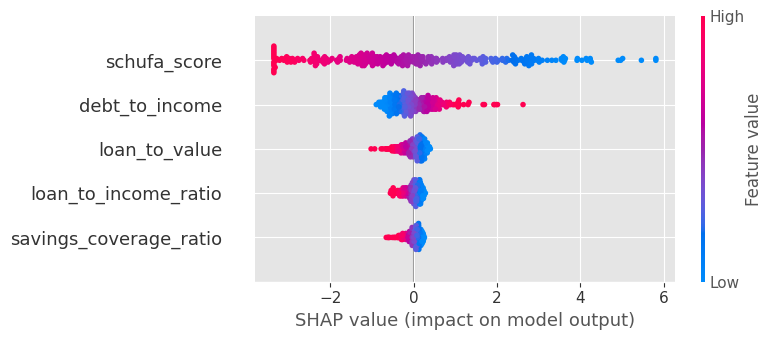

In [465]:

# 1. Extract trained pipeline components


imputer = log_pipeline_final.named_steps["imputer"]
scaler = log_pipeline_final.named_steps["scaler"]
log_model = log_pipeline_final.named_steps["model"]


# 2. Transform test data (same as model input)

# Impute
X_test_imputed = imputer.transform(X_test)

# Scale
X_test_scaled = scaler.transform(X_test_imputed)

# 3. Build SHAP explainer for logistic model

explainer = shap.LinearExplainer(log_model, X_test_scaled)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_scaled)

# 4. Summary Plot (Correctly Aligned)

shap.summary_plot(shap_values, X_test_scaled, feature_names=features)

Note: Since predicted PD feeds into Expected Loss (PD × LGD × EAD), probability calibration would be important in production. 
This case study focuses on discrimination (AUC/KS), but calibration analysis would be a natural next step before deployment.

# 4. Recommendations

### Key Insights
- Risk segmentation shows strong separation (Low ≈ 1.5% default vs High ≈ 7–8%).
- Default risk is primarily driven by credit quality (schufa_score) and affordability (debt burden / leverage).
- Current interest rates vary only slightly across risk tiers, suggesting limited risk-based pricing differentiation.

### Recommendation 1: Implement PD-tiered risk-based pricing
Use predicted PD (or risk segment) to apply a transparent pricing ladder (e.g., base + risk premium). This aligns expected loss with revenue and reduces underpricing of high-risk borrowers.

### Recommendation 2: Add affordability guardrails at origination
Introduce clear underwriting thresholds or policy actions for high burden borrowers (e.g., adjust tenor, require downpayment, reduce loan amount) based on debt-to-income and loan-to-income ratios.

### Recommendation 3: Separate origination risk from behavioral monitoring
Keep the logistic PD model as an origination scorecard (pre-approval). Build a second behavioral monitoring rule-set using early payment signals (e.g., on-time rate, trend in days late) to trigger proactive outreach and reduce losses.

### Recommendation 4: Strengthen data definitions to avoid leakage
Clarify whether `late_payments_90` represents bureau history or post-origination delinquency. This prevents leakage and improves trust in underwriting, monitoring, and pricing decisions.

# 5. Data Management & Model Integration

## Production Deployment in Cloover’s GCP Environment

Given that Cloover operates on GCP and BigQuery, the PD model can be integrated into the existing infrastructure in a clean and scalable way.

---

## 1 Data Architecture

Application and bureau data are likely stored in:

- Operational SQL database (e.g., PostgreSQL)
- BigQuery for analytics and reporting

Feature engineering can be handled in BigQuery using SQL transformations.

This allows:

- Centralised feature definitions
- Easy auditing of input variables
- Consistency between analytics and model scoring

The model should always score from a structured feature table (e.g., `underwriting_features_view`) maintained in BigQuery.

---

## 2 Model Serving on GCP

The trained logistic regression pipeline can be:

- Serialized using joblib
- Deployed as a lightweight API using FastAPI
- Containerised with Docker
- Hosted on Cloud Run

When a new loan application arrives:

1. Required features are pulled from the SQL/BigQuery layer.
2. The scoring service applies preprocessing.
3. The model returns:
   - Predicted Probability of Default (PD)
   - Risk tier

This output feeds directly into:
- Pricing engine
- Approval decision rules
- Capital allocation logic

Because the model is computationally simple, real-time scoring latency will be minimal.

---

## 3 Integration with Financial Models

The predicted PD integrates into pricing via:

Expected Loss = PD × LGD × EAD

This allows:

- Risk-based pricing adjustments
- Risk-adjusted profitability analysis
- Portfolio-level stress testing

The PD output can also be written back into BigQuery for tracking and monitoring.

---

## 4 Monitoring via BI Dashboards

To maintain model quality over time, monitoring dashboards should be built using:

- Looker (native to GCP)
- or Google Data Studio

Recommended monitoring metrics:

- Default rate by predicted risk tier
- PD vs realised default (calibration tracking)
- AUC / KS over rolling cohorts
- Portfolio distribution drift (feature PSI)

Dashboards should be updated automatically from BigQuery tables.

This ensures business teams (Risk, Finance, Operations) have transparent visibility into model performance.

---

## 5 Automated Retraining

Retraining can be orchestrated using:

- Cloud Composer (Airflow on GCP)
- Vertex AI Pipelines

Suggested retraining triggers:

- Quarterly schedule
- Significant feature drift
- Performance degradation beyond threshold

Retraining workflow:

1. Pull latest labelled cohort from BigQuery.
2. Recompute features.
3. Retrain logistic model.
4. Validate performance.
5. Deploy updated version to Cloud Run.

---

## Governance & Risk Controls

- Separate origination PD from behavioural monitoring models.
- Avoid leakage from post-origination variables.
- Maintain versioned training datasets in BigQuery.
- Log model versions and prediction outputs for audit.

---

## Final View

This setup ensures:

- Seamless integration with Cloover’s GCP stack
- Real-time underwriting decisions
- Transparent risk monitoring via BI dashboards
- Scalable retraining as the portfolio grows

The model remains simple, explainable, and operationally robust.